### Imports

In [176]:
import numpy as np
from scipy.io import loadmat
from ternary.helpers import project_sequence

import tensorflow as tf

from scipy.spatial.distance import pdist, squareform

import matplotlib.pyplot as plt
import ternary

from sklearn.manifold import spectral_embedding
from sklearn.mixture import GaussianMixture

import gpflow

### Load in the relevant data

In [177]:
# read the data from the control (fully autonomous) run
auto_order = np.loadtxt(fname='autonomous_predicted_labels.txt',
                        skiprows=1,
                        max_rows=1,
                        dtype=int)

auto_label = np.loadtxt(fname='autonomous_predicted_labels.txt',
                        skiprows=3)

# read the data from the run of interest
time_string = '2022-06-16-09-37'

test_order = np.loadtxt(fname=f'labels/predicted_labels_{time_string}.txt',
                        skiprows=1,
                        max_rows=1,
                        dtype=int)

test_label = np.loadtxt(fname=f'labels/predicted_labels_{time_string}.txt',
                        skiprows=3)

# import the experimental data, including the...
experimental_data = loadmat('FeGaPd_full_data_220104a.mat')

# ..."true" labels from the data set, ...
true_label = experimental_data['labels_col'][0][1].flatten()

# ...composition data in cartesian coordinates, ...
composition = experimental_data['C']
idx = [1, 2, 0]
cartesian = np.array(list(zip(*project_sequence(composition[:, idx]))))

# ...and x ray diffraction data
xrd = experimental_data['X'][:, 631:1181]

### Set the random seeds

In [178]:
# seed the numpy and tensorflow random number generation for reproducability
seed = 1
rng = np.random.RandomState(seed)
tf.random.set_seed(seed)

### Indicate which experiment iteration to simulate

In [236]:
measured = auto_order[:30]

### Calculate the clutering similarity matrix

In [237]:
sc_lengthscale = 0.7
# calculate the similarity matrix
pairwise_distance = squareform(pdist(xrd[measured, :], 'cosine'))
similarity_matrix = np.exp(-(pairwise_distance**2) / (2 * sc_lengthscale**2))

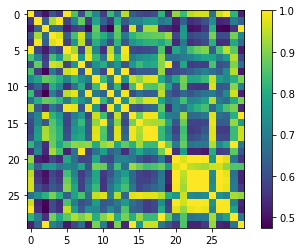

In [238]:
# display the similarity matrix
fig, ax = plt.subplots()
image = ax.imshow(similarity_matrix)
fig.colorbar(image)

plt.show()

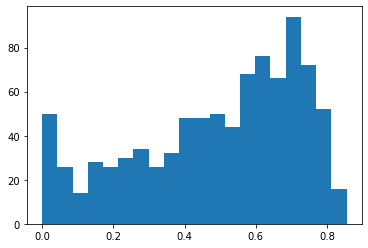

In [239]:
# histogram of similarities
fig, ax = plt.subplots()
ax.hist(pairwise_distance.flatten(), bins=20)

plt.show()

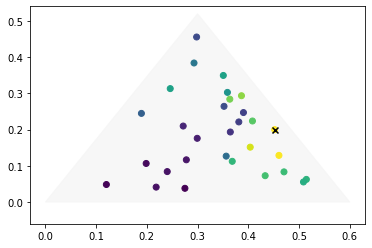

In [250]:
# plot the measured points colored based on their similarity to specified point
comparison_index = 10

fig, tax = ternary.figure(scale=0.6)

# the measured points
tax.get_axes().scatter(cartesian[measured, 0],
                       cartesian[measured, 1],
                       c=similarity_matrix[:, comparison_index])
                       
# the comparison point in black
tax.get_axes().scatter(cartesian[measured[comparison_index], 0],
                       cartesian[measured[comparison_index], 1],
                       marker='x',
                       c=[[0, 0, 0]])

plt.show()

### Perform the "ground truth" spectral clustering

In [241]:
num_clusters = 5

spectral_clusters = spectral_embedding(adjacency=similarity_matrix,
                              n_components=num_clusters,
                              random_state=rng)

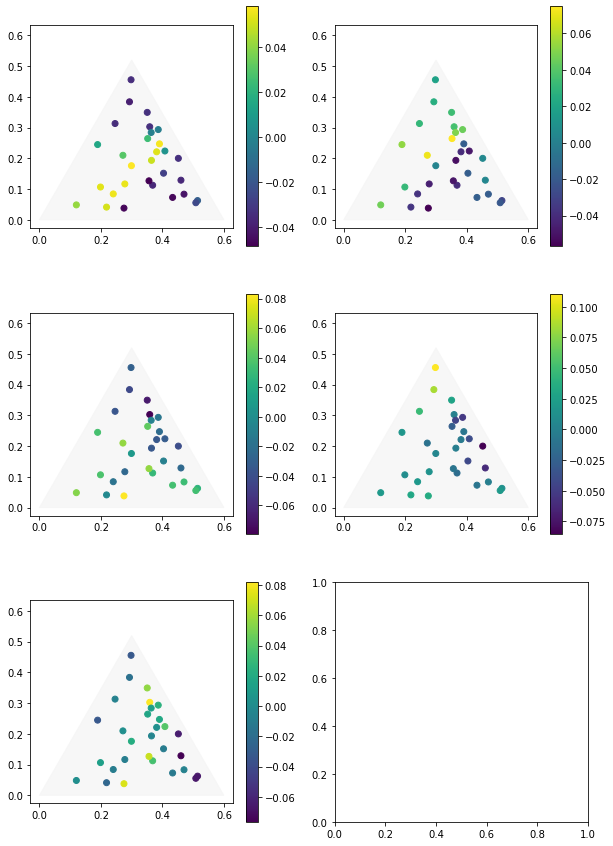

In [242]:
fig, ax = plt.subplots(3, 2, figsize=(10, 15))

for i in range(num_clusters):
    tax = ternary.TernaryAxesSubplot(ax=ax.flatten()[i], scale=0.6)

    # the measured points
    p = tax.get_axes().scatter(cartesian[measured, 0],
                           cartesian[measured, 1],
                           c=spectral_clusters[:, i])

    plt.colorbar(p, ax=ax.flatten()[i])

    tax.get_axes().axis('square')

plt.show()


In [243]:
mixture_model = GaussianMixture(n_components=num_clusters,
                                covariance_type='diag',
                                n_init=10,
                                random_state=rng).fit(spectral_clusters)

cluster_probabilities = mixture_model.predict_proba(spectral_clusters)


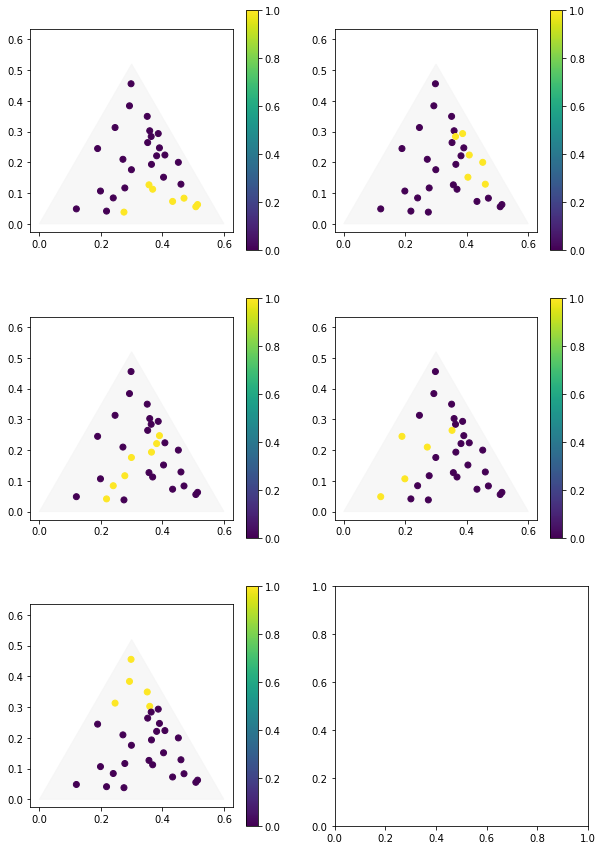

In [244]:
fig, ax = plt.subplots(3, 2, figsize=(10, 15))

for i in range(num_clusters):
    tax = ternary.TernaryAxesSubplot(ax=ax.flatten()[i], scale=0.6)

    # the measured points
    p = tax.get_axes().scatter(cartesian[measured, 0],
                           cartesian[measured, 1],
                           c=cluster_probabilities[:, i])

    plt.colorbar(p, ax=ax.flatten()[i])

    tax.get_axes().axis('square')

plt.show()

### Train the Gaussian Process Classifier on the Spectral Clustering

In [282]:
labels = np.argmax(cluster_probabilities, axis=1).flatten()

data = (cartesian[measured, :], labels)

kernel = gpflow.kernels.Matern32(lengthscales=[1, 1])

invlink = gpflow.likelihoods.RobustMax(num_clusters)

likelihood = gpflow.likelihoods.MultiClass(num_clusters, invlink=invlink)

gp_model = gpflow.models.VGP(data=data,
                             kernel=kernel,
                             likelihood=likelihood,
                             num_latent_gps=num_clusters)

opt = gpflow.optimizers.Scipy()
opt_result = opt.minimize(gp_model.training_loss,
                          gp_model.trainable_variables,
                          options={'maxiter': 1000})

print(opt_result)
gp_model


      fun: 56.4140235652887
 hess_inv: <2478x2478 LbfgsInvHessProduct with dtype=float64>
      jac: array([-1.09436188e-04,  3.23806001e-03, -2.06031583e-04, ...,
       -8.79927449e-03,  3.76873878e-03,  1.36536969e-05])
  message: 'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 190
      nit: 172
     njev: 190
   status: 0
  success: True
        x: array([-0.15735456, -0.43819081,  0.88720727, ..., -1.59494355,
       -1.74329388,  0.541246  ])


name,class,transform,prior,trainable,shape,dtype,value
VGP.kernel.variance,Parameter,Softplus,,True,(),float64,0.9999501521153517
VGP.kernel.lengthscales,Parameter,Softplus,,True,"(2,)",float64,[0.18475192 0.16121981]
VGP.likelihood.invlink.epsilon,Parameter,Sigmoid,Beta,False,(),float64,0.0010000000000000005
VGP.num_data,Parameter,Identity,,False,(),int32,30
VGP.q_mu,Parameter,Identity,,True,"(30, 5)",float64,"[[-1.57354559e-01, -4.38190805e-01, 8.87207275e-01..."
VGP.q_sqrt,Parameter,FillTriangular,,True,"(5, 30, 30)",float64,"[[[3.57601404e-01, 0.00000000e+00, 0.00000000e+00..."


In [246]:
y_mean, y_variance = tuple(t.numpy() for t in gp_model.predict_y(cartesian))
f_mean, f_variance = tuple(t.numpy() for t in gp_model.predict_f(cartesian))

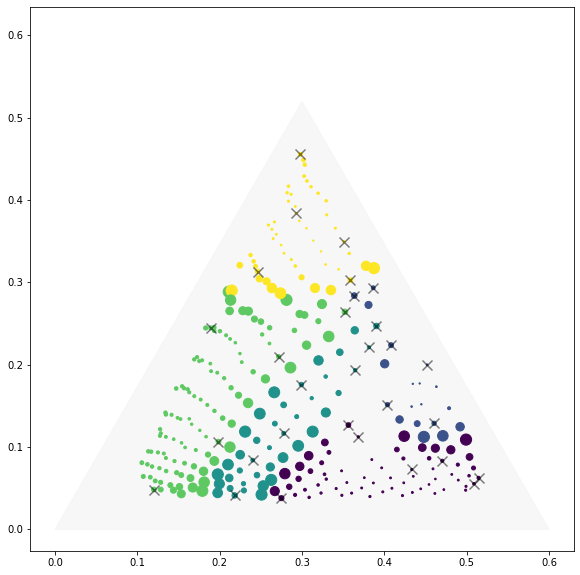

In [306]:
gp_labels = np.argmax(y_mean, axis=1)

fig, ax = plt.subplots(figsize=(10, 10))
tax = ternary.TernaryAxesSubplot(ax, scale=0.6)

label_variances = [v[l] for v, l in zip(y_variance, gp_labels)]

tax.get_axes().scatter(cartesian[:, 0],
                       cartesian[:, 1],
                       c=gp_labels,
                       s=[500 * variance for variance in label_variances])

tax.get_axes().scatter(cartesian[measured, 0],
                       cartesian[measured, 1],
                       color=[0, 0, 0, 0.5],
                       marker='x',
                       s=100)                     

tax.get_axes().axis('square')

plt.show()

### Train the Gaussian Process Classifier on the Spectral Clustering and Human Input

In [266]:
# human input points
points = [(0.2, 0.3), (0.4, 0.3)]

x1, y1 = points[0]
x2, y2 = points[1]

# calculate the distance between each point the line
boundary_distance = [(x-x1)*(y2-y1)-(y-y1)*(x2-x1) for (x, y) in cartesian]

user_labels = [1 if d > 0 else 0 for d in boundary_distance]

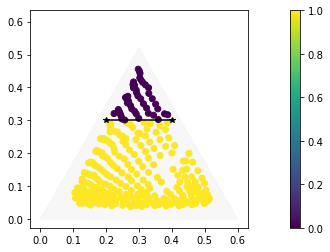

In [267]:
fig, tax = ternary.figure(scale=0.6)

# plot user points
x, y = zip(*points)

tax.get_axes().plot(x, y, 'k*-')

# plot samples, colored by user labels
p = tax.get_axes().scatter(cartesian[:, 0],
                           cartesian[:, 1],
                           c=user_labels)

plt.colorbar(p)

tax.get_axes().axis('square')

plt.show()


In [292]:
# kernel for user input
prior_kernel = gpflow.kernels.SquaredExponential(active_dims=[2],
                                                 lengthscales=1,
                                                 variance=0.5)

# fix the prior kernel lengthscale and variance
gpflow.utilities.set_trainable(prior_kernel.parameters[1], False)
gpflow.utilities.set_trainable(prior_kernel.parameters[0], False)

# add prior kernel to clustering kernel
hitl_kernel = gpflow.kernels.Matern32(active_dims=[0, 1]) + prior_kernel

# organize hitl input data
hitl_data = np.column_stack((cartesian, user_labels))

hitl_input = (hitl_data[measured, :], labels)

invlink = gpflow.likelihoods.RobustMax(num_clusters)

likelihood = gpflow.likelihoods.MultiClass(num_clusters, invlink=invlink)

hitl_gp_model = gpflow.models.VGP(data=hitl_input,
                                  kernel=hitl_kernel,
                                  likelihood=likelihood,
                                  num_latent_gps=num_clusters)

opt = gpflow.optimizers.Scipy()
opt_result = opt.minimize(gp_model.training_loss,
                          gp_model.trainable_variables,
                          options={'maxiter': 1000, 'disp':101})

print(opt_result)
hitl_gp_model

      fun: 56.41402299249802
 hess_inv: <2478x2478 LbfgsInvHessProduct with dtype=float64>
      jac: array([-4.11288040e-04,  2.10463784e-03,  2.08534005e-04, ...,
       -4.39548100e-03,  6.27986083e-03,  1.36585433e-05])
  message: 'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 3
      nit: 1
     njev: 3
   status: 0
  success: True
        x: array([-0.15735278, -0.43819485,  0.88720034, ..., -1.59493053,
       -1.74327581,  0.54124559])


name,class,transform,prior,trainable,shape,dtype,value
VGP.kernel.kernels[0].variance,Parameter,Softplus,,True,(),float64,0.9999999999999999
VGP.kernel.kernels[0].lengthscales,Parameter,Softplus,,True,(),float64,0.9999999999999999
VGP.kernel.kernels[1].variance,Parameter,Softplus,,False,(),float64,0.5
VGP.kernel.kernels[1].lengthscales,Parameter,Softplus,,False,(),float64,0.9999999999999999
VGP.likelihood.invlink.epsilon,Parameter,Sigmoid,Beta,False,(),float64,0.0010000000000000005
VGP.num_data,Parameter,Identity,,False,(),int32,30
VGP.q_mu,Parameter,Identity,,True,"(30, 5)",float64,"[[0., 0., 0...."
VGP.q_sqrt,Parameter,FillTriangular,,True,"(5, 30, 30)",float64,"[[[1., 0., 0...."


In [288]:
print(opt_result.x.shape)

(2478,)


In [293]:
hitl_y_mean, hitl_y_variance = tuple(
    t.numpy() for t in hitl_gp_model.predict_y(hitl_data))
hitl_f_mean, hitl_f_variance = tuple(
    t.numpy() for t in hitl_gp_model.predict_f(hitl_data))

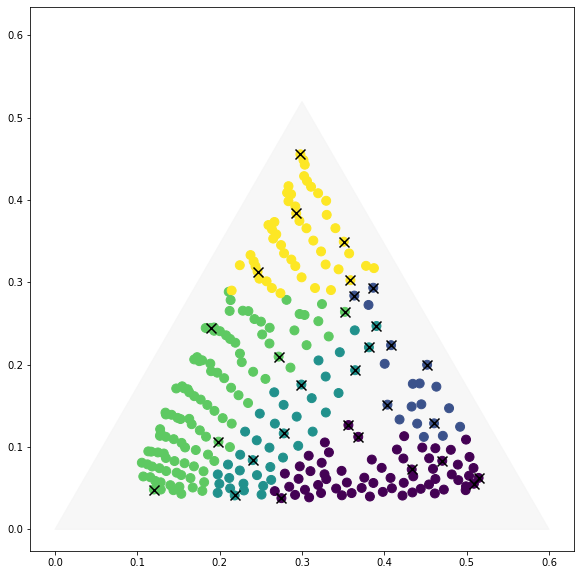

In [305]:
hitl_gp_labels = np.argmax(hitl_y_mean, axis=1)

fig, ax = plt.subplots(figsize=(10, 10))
tax = ternary.TernaryAxesSubplot(ax, scale=0.6)

hitl_label_variances = [v[l] for v, l in zip(hitl_y_variance, hitl_gp_labels)]

tax.get_axes().scatter(cartesian[:, 0],
                       cartesian[:, 1],
                       c=gp_labels,
                       s=[500 * variance for variance in hitl_label_variances])

tax.get_axes().scatter(cartesian[measured, 0],
                       cartesian[measured, 1],
                       color=[0, 0, 0],
                       marker='x',
                       s=100)                     

tax.get_axes().axis('square')

plt.show()

In [295]:
hitl_gp_model

name,class,transform,prior,trainable,shape,dtype,value
VGP.kernel.kernels[0].variance,Parameter,Softplus,,True,(),float64,0.9999999999999999
VGP.kernel.kernels[0].lengthscales,Parameter,Softplus,,True,(),float64,0.9999999999999999
VGP.kernel.kernels[1].variance,Parameter,Softplus,,False,(),float64,0.5
VGP.kernel.kernels[1].lengthscales,Parameter,Softplus,,False,(),float64,0.9999999999999999
VGP.likelihood.invlink.epsilon,Parameter,Sigmoid,Beta,False,(),float64,0.0010000000000000005
VGP.num_data,Parameter,Identity,,False,(),int32,30
VGP.q_mu,Parameter,Identity,,True,"(30, 5)",float64,"[[0., 0., 0...."
VGP.q_sqrt,Parameter,FillTriangular,,True,"(5, 30, 30)",float64,"[[[1., 0., 0...."
